In [1]:
import os
from urllib.parse import urlparse
import random
import yaml
from shapely.geometry import box, mapping
from eopf.store.convert import convert
import boto3
import pystac_client
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

import glob
import natsort
import xarray as xr
import sys

from eopf.common.constants import OpeningMode
from eopf.common.file_utils import AnyPath

/home/ubuntu/.conda/envs/eopf/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:13: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


# Functions needed for the test

In [2]:
def load_config(config_path):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def setup_environment(config):
    """Set up environment variables and directories for the dataset"""
    # Keep these from environment variables
    ACCESS_KEY_ID = 'MLTFR0SO1BCGFUV70UH5'
    SECRET_ACCESS_KEY = 'vhy1H1QErCukTooZgugD3YJl76jWqm3a5k1CpN51'

    # Get other parameters from config
    ENDPOINT_URL = config['endpoint_url']
    ENDPOINT_STAC = config['endpoint_stac']
    BUCKET_NAME = config['bucket_name']
    DATASET_VERSION = config['dataset_version']
    BASE_DIR = config['base_dir']
    DATASET_DIR = f"{BASE_DIR}/{DATASET_VERSION}"
    BANDS = config['bands']

    # Setup connector
    connector = S3Connector(
        endpoint_url=ENDPOINT_URL,
        access_key_id=ACCESS_KEY_ID,
        secret_access_key=SECRET_ACCESS_KEY,
        region_name='default')

    buckets = connector.list_buckets()
    print("Available buckets:", buckets)

    s3 = connector.get_s3_resource()
    s3_client = connector.get_s3_client()

    return {
        'ACCESS_KEY_ID': ACCESS_KEY_ID,
        'SECRET_ACCESS_KEY': SECRET_ACCESS_KEY,
        'ENDPOINT_URL': ENDPOINT_URL,
        'ENDPOINT_STAC':ENDPOINT_STAC,
        'BUCKET_NAME': BUCKET_NAME,
        'DATASET_DIR': DATASET_DIR,
        'BANDS': BANDS,
        's3_client': connector.get_s3_client(),
        's3': connector.get_s3_resource()
    }


def download(bucket, product: str, target: str = "") -> str:
    if not product.endswith('/'):
        product += '/'
    files = list(bucket.objects.filter(Prefix=product))
    if not files:
        raise FileNotFoundError(f"Could not find any files for {product}")
    safe_dir = os.path.basename(product.rstrip('/'))
    if not safe_dir.endswith('.SAFE'):
        raise ValueError(f"Expected a .SAFE directory, got: {safe_dir}")
    local_path = os.path.join(target, safe_dir)
    os.makedirs(local_path, exist_ok=True)

    for file in files:
        if file.key.endswith('/'):
            continue
        relative_path = os.path.relpath(file.key, product)
        local_file_path = os.path.join(local_path, relative_path)
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        bucket.download_file(file.key, local_file_path)
    return local_path


def get_chunk_info(data_tree, band, res):
    """
    Extract chunk size and number of chunks from a dataset.

    Parameters:
    - data_tree: xarray.DataTree
    - band: str, e.g. "b03"
    - resolution: str, y-dimension name (e.g. "y_10m")
    - x_res: str, x-dimension name (e.g. "x_10m")

    Returns:
    - chunk_size_y: int
    - chunk_size_x: int
    - nb_chunks_y: int
    - nb_chunks_x: int
    """
    res_key = f"r{res}"
    y_res = f"y"
    x_res = f"x"
    data_tree = data_tree.measurements.reflectance[res_key]

    chunk_size_y = data_tree[band].chunksizes[y_res][0]
    chunk_size_x = data_tree[band].chunksizes[x_res][0]
    nb_chunks_y = len(data_tree[band].chunksizes[y_res])
    nb_chunks_x = len(data_tree[band].chunksizes[x_res])

    print(f"Chunk size: y={chunk_size_y}, x={chunk_size_x}")
    print(f"Number of chunks: y={nb_chunks_y}, x={nb_chunks_x}")

    return chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x


def extract_s3_path_from_url(url):
    """
    Extracts the S3 object path from an S3 URL or URI.

    This function parses S3 URLs/URIs and returns just the object path portion,
    removing the protocol (s3://), bucket name, and any leading slashes.

    Args:
        url (str): The full S3 URI (e.g., 's3://eodata/path/to/file.jp2')

    Returns:
        str: The S3 object path (without protocol, bucket name and leading slashes)
    """
    # If it's not an S3 URI, return it unchanged
    if not url.startswith('s3://'):
        return url

    # Parse the S3 URI
    parsed_url = urlparse(url)

    # Ensure this is an S3 URL
    if parsed_url.scheme != 's3':
        raise ValueError(f"URL {url} is not an S3 URL")

    # Extract the path without leading slashes
    object_path = parsed_url.path.lstrip('/')

    return object_path

In [3]:
class S3Connector:
    """A clean connector for S3-compatible storage services"""

    def __init__(self, endpoint_url, access_key_id,
                 secret_access_key, region_name='default'):
        """Initialize the S3Connector with connection parameters"""
        self.endpoint_url = endpoint_url
        self.access_key_id = access_key_id
        self.secret_access_key = secret_access_key
        self.region_name = region_name

        # Create session
        self.session = boto3.session.Session()

        # Initialize S3 resource
        self.s3 = self.session.resource(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

        # Initialize S3 client
        self.s3_client = self.session.client(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

    def get_s3_client(self):
        """Get the boto3 S3 client"""
        return self.s3_client

    def get_s3_resource(self):
        """Get the boto3 S3 resource"""
        return self.s3

    def get_bucket(self, bucket_name):
        """Get a specific bucket by name"""
        return self.s3.Bucket(bucket_name)

    def list_buckets(self):
        """List all available buckets"""
        response = self.s3_client.list_buckets()
        if 'Buckets' in response:
            return [bucket['Name'] for bucket in response['Buckets']]
        return []

In [4]:
def plot_all_chunks(data_tree, band, res, chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x, cmap="viridis", verbose= True, figsize_scale=3):
    """
    Plot all chunks of a given band and resolution.

    Parameters:
    - data_tree: xarray Dataset (e.g. dt.measurements.reflectance.r20m)
    - band: str, band name (e.g. "b05")
    - cmap: str, matplotlib colormap
    - figsize_scale: int, scales the figure size (default is 3)
    """
    res_key = f"r{res}"
    y_res = 'y' #MODIFIED
    x_res = 'x'
    data_tree = data_tree.measurements.reflectance[res_key]
    # Set up plot grid
    fig, axes = plt.subplots(
        nb_chunks_y, nb_chunks_x,
        figsize=(figsize_scale * nb_chunks_x, figsize_scale * nb_chunks_y)
    )

    # Plot each chunk
    for i in range(nb_chunks_y):
        for j in range(nb_chunks_x):
            ax = axes[i, j] if nb_chunks_y > 1 else axes[j]
            y_start = i * chunk_size_y
            x_start = j * chunk_size_x
            chunk = data_tree[band].isel(
                {y_res: slice(y_start, y_start + chunk_size_y),
                 x_res: slice(x_start, x_start + chunk_size_x)}
            ).load()
            ax.imshow(chunk, cmap=cmap, vmin=float(chunk.min()), vmax=float(chunk.max()))
            ax.set_title(f"Chunk ({i},{j})")
            ax.axis("off")
    if verbose:
        plt.tight_layout()
        plt.savefig("chunks_plot.png", dpi=300)

# Testing

In [5]:
# Configuration parameters

config_path = '/home/ubuntu/mucilage_pipeline/mucilage-detection/src/cfg/config_dataset.yaml'
config = load_config(config_path)
env = setup_environment(config)
catalog = pystac_client.Client.open(env['ENDPOINT_STAC'])

# Extract bbox from config query
bbox = config['query']['bbox']  # [min_lon, min_lat, max_lon, max_lat]

# Create GeoJSON polygon from bbox
polygon_geojson = mapping(box(*bbox))
start_date = config['query']['start_date']
end_date = config['query']['end_date']
max_cloud_cover = config['query']['max_cloud_cover']

datetime_range = f"{start_date}/{end_date}"

# Perform search
items = catalog.search(
    collections=['sentinel-2-l2a'],
    intersects=polygon_geojson,
    datetime=datetime_range,
    query=[f"eo:cloud_cover<{max_cloud_cover}"]
)

Available buckets: ['DIAS', 'EODATA']


In [6]:
# Download all the files as .SAFE

items_list = list(items.items())
print(f"Found {len(items_list)} matching products.")

if not items_list:
    print("No items found")

zarr_paths = []
for item in items_list:
    product_url, _ = os.path.split(item.assets['safe_manifest'].href)
    product_url = extract_s3_path_from_url(product_url)

    print(f"Downloading: {product_url}")
    #safe_path = download(bucket, product_url, target=os.getcwd())

Found 22 matching products.
Downloading: Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T33TUL_20240728T114034.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T33TUK_20240728T114034.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQR_20240728T114034.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQQ_20240728T114034.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/26/S2A_MSIL2A_20240726T100601_N0511_R022_T33TUL_20240726T193850.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/26/S2A_MSIL2A_20240726T100601_N0511_R022_T33TUK_20240726T193850.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/26/S2A_MSIL2A_20240726T100601_N0511_R022_T32TQR_20240726T193850.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/26/S2A_MSIL2A_20240726T100601_N0511_R022_T32TQQ_20240726T193850.SAFE
Downloading: Sentinel-2/MSI/L2A/2024/07/23/S2A_MSIL2A_20240723T100031_N0511_R122_T33TUK_20240723T155

In [15]:
for item in items.item_collection():
    print(item.id)  # usually includes tile ID (e.g., TPF or TPE)
    print(item.geometry)
    print(item.assets['safe_manifest'].href)

S2B_MSIL2A_20240728T095549_N0511_R122_T33TUL_20240728T114034
{'type': 'Polygon', 'coordinates': [[[12.424645070169124, 45.832610704010406], [12.428970892050708, 45.84510488113258], [12.479821543426572, 45.991651764295], [12.492333987637313, 46.02560721362705], [13.834108089722305, 46.0476276229589], [13.854365464520265, 45.05951360004942], [12.460785793001175, 45.037023116804335], [12.424645070169124, 45.832610704010406]]]}
s3://eodata/Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T33TUL_20240728T114034.SAFE/manifest.safe
S2B_MSIL2A_20240728T095549_N0511_R122_T33TUK_20240728T114034
{'type': 'Polygon', 'coordinates': [[[12.456860516996768, 45.12551356202371], [13.852592618382664, 45.148073182871244], [13.87191870410008, 44.15979663371134], [12.499651613106883, 44.137996748196564], [12.456860516996768, 45.12551356202371]]]}
s3://eodata/Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T33TUK_20240728T114034.SAFE/manifest.safe
S2B_MSIL2A_20240728T09

In [18]:
# Download one .SAFE then convert into .zarr

selected_item = random.choice(items.item_collection())
selected_item = list(items.item_collection())[2]
#safe_filename = download(bucket, product_url, target=".")
product_url , _ = os.path.split(selected_item.assets['safe_manifest'].href)
# Replace .SAFE with .zarr
zarr_filename =  os.path.split(product_url)[1].replace('.SAFE', '.zarr')
# Join the current directory path with the new filename
data_dir = '/home/ubuntu/mucilage_pipeline/mucilage-detection/data'
zarr_path = os.path.join(data_dir, zarr_filename)
#convert(safe_filename, zarr_path, mask_and_scale=True)

In [19]:
print(product_url)

s3://eodata/Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQR_20240728T114034.SAFE


In [18]:
# Convert into .zarr on the flight

S3_CONFIG = {
    "key": env['ACCESS_KEY_ID'], # EDIT WITH YOUR S3 KEY
    "secret": env['SECRET_ACCESS_KEY'], # EDIT WITH YOUR S3 SECRET KEY
    "client_kwargs": { "endpoint_url": env['ENDPOINT_URL'], "region_name": "default"} # EDIT WITH YOUR CLIENT_KWARGS
}
# Add this parameter if you want to overwrite the output of the conversion if it already exists
target_store_config = dict(mode=OpeningMode.CREATE_OVERWRITE)

# For the zarr store we don't need to add the storage_options argument because we want to write the target product locally
convert(AnyPath(product_url, **S3_CONFIG), zarr_path, target_store_kwargs=target_store_config)

INFO:eopf.daskconfig.dask_context_manager:Initialising an ClusterType.LOCAL cluster with client conf : {} ,cluster config {'n_workers': 1} and dask config {}
INFO:eopf.daskconfig.dask_context_manager:DASK Cluster : LocalCluster(619f1647, 'tcp://127.0.0.1:33399', workers=1, threads=8, memory=23.47 GiB)
INFO:eopf.daskconfig.dask_context_manager:Dask Client : <Client: 'tcp://127.0.0.1:33399' processes=1 threads=8, memory=23.47 GiB>
INFO:eopf.daskconfig.dask_context_manager:Dask dashboard address: http://127.0.0.1:8787/status
INFO:eopf.store.convert:Converting eodata/Sentinel-2/MSI/L2A/2024/07/28/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQR_20240728T114034.SAFE to /home/ubuntu/mucilage_pipeline/mucilage-detection/data/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQR_20240728T114034.zarr
INFO:eopf.store.safe:Found product type : S02MSIL2A with processing version: 05.00
ECCODES ERROR   :  unable to represent the step in h
                    Hint: try changing the step units
ECCODES ERROR   :  u

TimeoutError: 

In [2]:
# Load zarr datatree

dt = xr.open_datatree('/home/ubuntu/mucilage_pipeline/DeltaTwin/data/target/S2C_MSIL2A_20250807T100041_N0511_R122_T33TUJ_20250807T122013.zarr', engine="zarr", mask_and_scale=False, chunks={})
ds = dt.measurements.reflectance

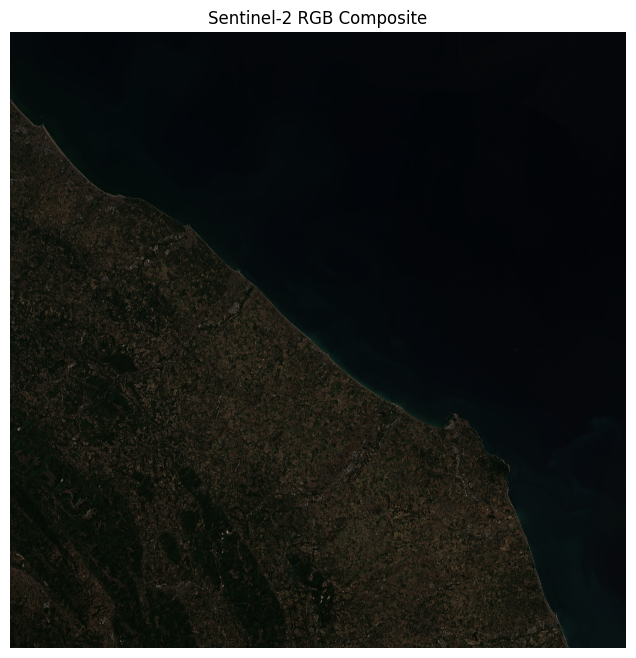

In [3]:
# Plot RGB

rgb = np.dstack([
    ds['r10m']['b04'].values,
    ds['r10m']['b03'].values,
    ds['r10m']['b02'].values
])
# Plot
plt.figure(figsize=(12, 8))
plt.imshow(rgb)
plt.axis('off')
plt.title('Sentinel-2 RGB Composite')
plt.show()

In [42]:
print(selected_item.id)
print("bbox:", selected_item.bbox)
print("geometry area (deg2):", selected_item.geometry)  # you can inspect geometry

# compute approximate area (km^2) using shapely + proj (optional)
from shapely.geometry import shape
from pyproj import Transformer
geom = shape(selected_item.geometry)
print("geom bounds:", geom.bounds)

S2B_MSIL2A_20240728T095549_N0511_R122_T33TUK_20240728T114034
bbox: [12.456861, 44.137997, 13.871919, 45.148073]
geometry area (deg2): {'type': 'Polygon', 'coordinates': [[[12.456860516996768, 45.12551356202371], [13.852592618382664, 45.148073182871244], [13.87191870410008, 44.15979663371134], [12.499651613106883, 44.137996748196564], [12.456860516996768, 45.12551356202371]]]}
geom bounds: (12.456860516996768, 44.137996748196564, 13.87191870410008, 45.148073182871244)


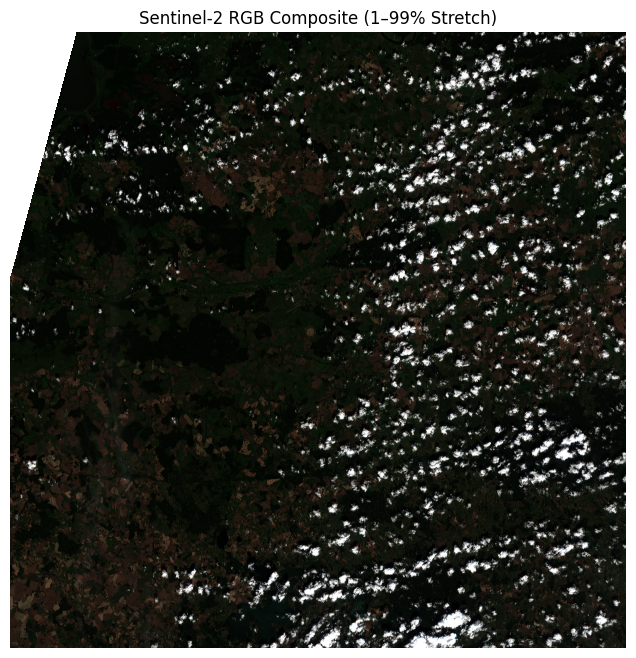

In [6]:
# Convert to reflectance (0–1)
rgb = np.dstack([
    ds['r10m']['b04'].values.astype(np.float32) / 10000,  # Red
    ds['r10m']['b03'].values.astype(np.float32) / 10000,  # Green
    ds['r10m']['b02'].values.astype(np.float32) / 10000   # Blue
])

# Per-channel percentile stretch, ignoring NaNs
rgb_stretched = np.zeros_like(rgb, dtype=np.float32)
for i in range(3):
    band = rgb[:, :, i]
    p_low, p_high = np.nanpercentile(band, (1, 99))  # NaN-safe
    scale = p_high - p_low if (p_high - p_low) != 0 else 1e-6
    rgb_stretched[:, :, i] = np.clip((band - p_low) / scale, 0, 1)

# Display
plt.figure(figsize=(12, 8))
plt.imshow(rgb_stretched)
plt.axis('off')
plt.title('Sentinel-2 RGB Composite (1–99% Stretch)')
plt.show()

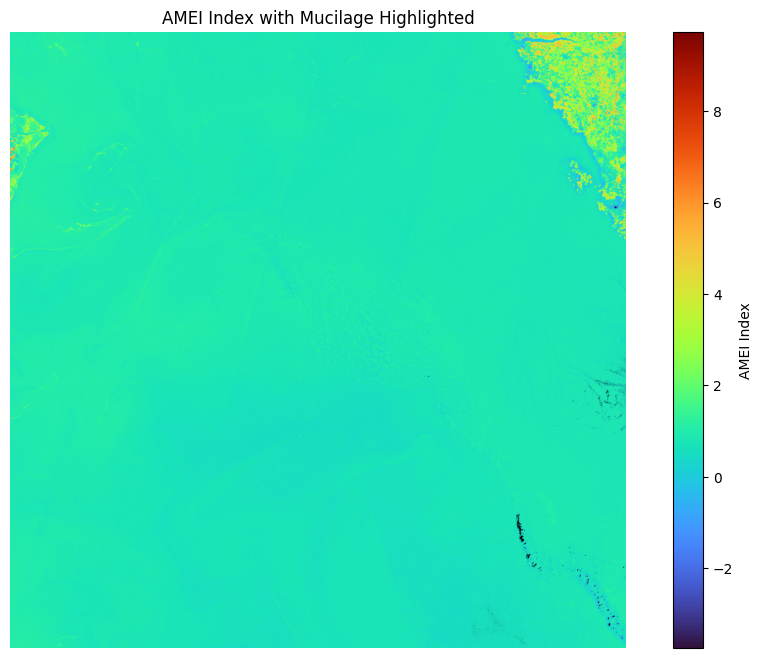

In [14]:
# Plot AMEI

red = ds['r20m']['b04'].values.astype(np.float32) / 10000
green = ds['r20m']['b03'].values.astype(np.float32) / 10000
nir = ds['r20m']['b8a'].values.astype(np.float32) / 10000
swir = ds['r20m']['b12'].values.astype(np.float32) / 10000

epsilon = 1e-6  # Small constant to avoid division by zero
denominator = green + (0.25 * swir)

amei = np.full_like(red, np.nan, dtype=np.float32)
# Mask pixels where denominator is too small or NaN
valid_mask = (denominator > epsilon) & np.isfinite(denominator)
amei[valid_mask] = ((2 * red[valid_mask]) + nir[valid_mask] - (2 * swir[valid_mask])) / denominator[valid_mask]
amei_filtered = np.where((amei < 10) & np.isfinite(amei), amei, np.nan)

# # Define mucilage threshold
# threshold = 3

# # Create mask for mucilage pixels
# mucilage_mask = (amei_masked > threshold)

# Plot AMEI full range with masked NaNs
plt.figure(figsize=(12,8))
cmap = plt.cm.turbo
cmap.set_bad(color='black')  # NaNs shown as black

im = plt.imshow(amei_filtered, cmap=cmap)
plt.colorbar(im, label='AMEI Index')

# Overlay mucilage pixels in red (alpha for transparency)
# plt.imshow(np.ma.masked_where(~mucilage_mask, mucilage_mask), cmap='Reds', alpha=0.6)

plt.title('AMEI Index with Mucilage Highlighted')
plt.axis('off')
plt.show()

Chunk size: y=1830, x=1830
Number of chunks: y=6, x=6


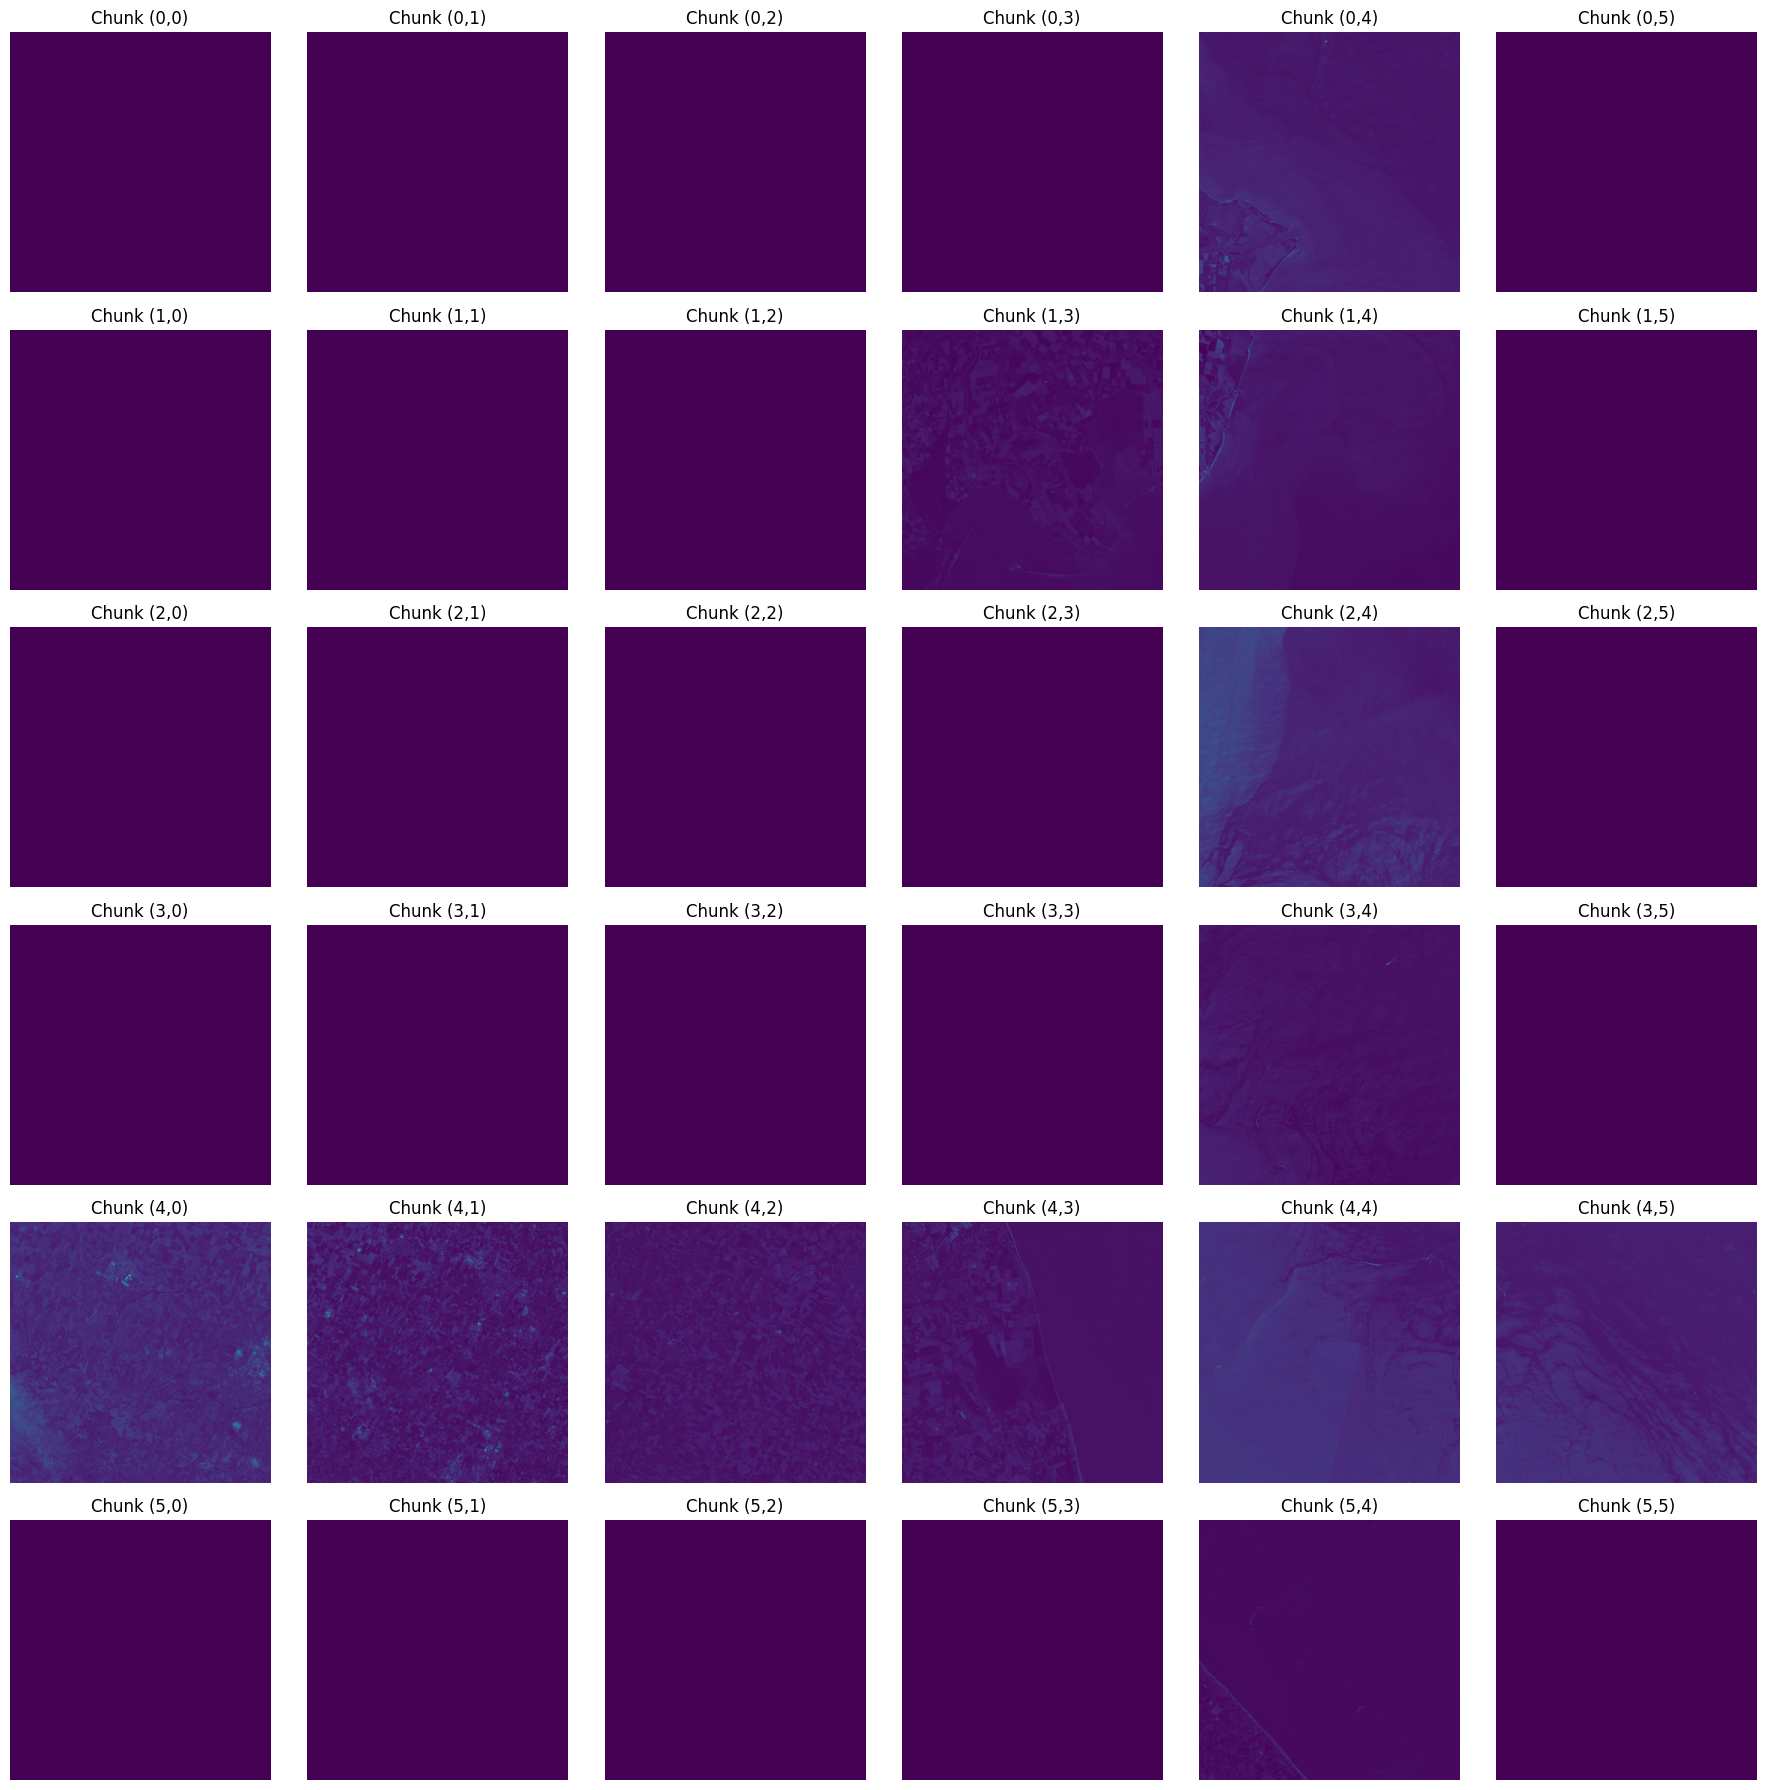

In [11]:
# Create and plot chunks

band = "b02"
res = "10m"
chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x = get_chunk_info(data_tree=dt, band=band, res=res)
plot_all_chunks(dt, band, res, chunk_size_y, chunk_size_x, nb_chunks_y, nb_chunks_x, cmap="viridis", verbose= True, figsize_scale=3)